In [ ]:
# Mount the drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#Imports
from tensorflow.keras import layers  # Importing specific layers from Keras for building the model
from tensorflow.keras.models import Sequential, load_model  # Importing Sequential model and load_model function
from tensorflow.keras.callbacks import EarlyStopping  # Importing EarlyStopping callback for early stopping during training
from tensorflow.keras.preprocessing.text import Tokenizer  # Importing Tokenizer for text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Importing pad_sequences for sequence padding
from sklearn.preprocessing import MultiLabelBinarizer  # Importing MultiLabelBinarizer for multi-label binarization
from sklearn.model_selection import train_test_split  # Importing train_test_split for splitting the dataset
import matplotlib.pyplot as plt  # Importing matplotlib for plotting
from ast import literal_eval  # Importing literal_eval to convert string labels to list of strings
import pandas as pd  # Importing pandas for data manipulation

In [ ]:
# Load the dataset
arxiv_data = pd.read_csv("/content/drive/MyDrive/IML-Recommender-Paper/arxiv_data.csv")

# Drop duplicate entries
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]

# Convert string labels to list of strings
arxiv_data["terms"] = arxiv_data["terms"].apply(lambda x: literal_eval(x))

# Explode the "terms" column into individual rows
arxiv_data_exploded = arxiv_data.explode("terms")

# Filter out rare terms based on occurrence count
term_counts = arxiv_data_exploded["terms"].value_counts()
common_terms = term_counts[term_counts > 1].index
arxiv_data_filtered = arxiv_data_exploded[arxiv_data_exploded["terms"].isin(common_terms)]

# Aggregate back if necessary
arxiv_data_filtered = arxiv_data_filtered.groupby(arxiv_data_filtered.index).agg(list)


In [ ]:
## Multi-label binarization

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Fit and transform the multi-labels into binary form
labels_binarized = mlb.fit_transform(arxiv_data_filtered["terms"])


In [ ]:
## Data preprocessing

# Tokenize the text data
tokenizer = Tokenizer()
# Fit tokenizer on the text data
tokenizer.fit_on_texts(arxiv_data_filtered["summaries"])

# Pad sequences to ensure uniform length
max_seq_length = 150
 # Convert text data to sequences
sequences = tokenizer.texts_to_sequences(arxiv_data_filtered["summaries"])
# Pad sequences to maximum length
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')


In [ ]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels_binarized, test_size=0.2, random_state=42)


In [ ]:
# Vocabulary size for embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
## Create CNN model

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=max_seq_length),  # Embedding layer
    layers.Conv1D(128, 5, activation='relu'),  # Convolutional layer
    layers.GlobalMaxPooling1D(),  # Global max pooling layer
    layers.Dense(128, activation='relu'),  # Dense layer
    layers.Dense(len(mlb.classes_), activation='sigmoid')  # Output layer with sigmoid activation for multi-label classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
## Train the model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[EarlyStopping(patience=3)])

## Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
439/439 [==============================] - 8s 7ms/step - loss: 0.0430 - accuracy: 0.4611 - val_loss: 0.0132 - val_accuracy: 0.5475
Epoch 2/20
439/439 [==============================] - 3s 6ms/step - loss: 0.0122 - accuracy: 0.5750 - val_loss: 0.0131 - val_accuracy: 0.5465
Epoch 3/20
439/439 [==============================] - 4s 9ms/step - loss: 0.0096 - accuracy: 0.7146 - val_loss: 0.0147 - val_accuracy: 0.5430
Epoch 4/20
439/439 [==============================] - 5s 11ms/step - loss: 0.0082 - accuracy: 0.6830 - val_loss: 0.0148 - val_accuracy: 0.5475
Epoch 5/20
244/244 [==============================] - 1s 4ms/step - loss: 0.0160 - accuracy: 0.5450
Test Accuracy: 54.50%


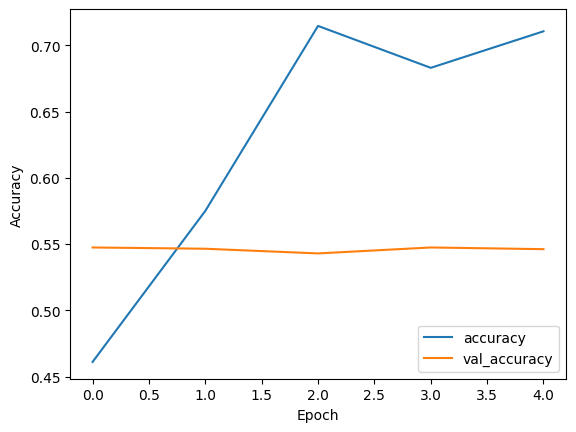

In [ ]:
## Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
## Inference
predicted_probabilities = model.predict(X_test)

# Inverse transform the labels
inverse_labels = mlb.inverse_transform(y_test)  #used to transform the binary representation of labels back into their original format.

# Inverse transform the predicted labels
predicted_labels = mlb.inverse_transform((predicted_probabilities > 0.5).astype(int))

# Print sample predictions
for i in range(5):
    print(f"True terms: {inverse_labels[i]}")
    print(f"Predicted terms: {predicted_labels[i]}")
    print()


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/IML-Recommender-Paper/subject_area_prediction')


In [ ]:

# Function to load the saved model
def load_saved_model(model_path):
    loaded_model = load_model(model_path)
    return loaded_model

# Load the saved model
saved_model_path = '/content/drive/MyDrive/IML-Recommender-Paper/subject_area_prediction'
loaded_model = load_saved_model(saved_model_path)

In [ ]:
# Function to preprocess input abstract and predict subject area/domain using the loaded model
def predict_subject_area_saved_model(abstract, loaded_model):
    # Tokenize the input abstract
    abstract_sequence = tokenizer.texts_to_sequences([abstract])
    # Pad the sequence
    padded_sequence = pad_sequences(abstract_sequence, maxlen=max_seq_length, padding='post')
    # Predict subject area/domain
    predicted_probabilities = loaded_model.predict(padded_sequence)
    # Inverse transform the predicted labels
    predicted_labels = mlb.inverse_transform((predicted_probabilities > 0.5).astype(int))
    return predicted_labels[0]


In [ ]:
# Example usage with the loaded model
input_abstract = "Higher Education plays a principal role in the changing and complex world of today, and there has been rapid growth in the scientific literature dedicated to predicting students' academic success or risk of dropout thanks to advances in Data Mining techniques. Degrees such as Computer Science in particular are in ever greater demand. Although the number of students has increased, the number graduating is still not enough to provide society with as many as it requires. This study contributes to reversing this situation by introducing an approach that not only predicts the dropout risk or students' performance but takes action to help both students and educational institutions. The focus is on maximizing graduation rates by constructing a Recommender System to assist students with their selection of subjects. In particular, the challenge is addressed of constructing reliable Recommender Systems on the basis of data which are both sparse and few in quantity, imbalanced, and anonymized, and which might have been stored under imperfect conditions. This approach is successfully applied to create a Recommender System using a real-world dataset from a public Spanish university containing performance data of a Computer Science degree course, demonstrating its successful application in real environments. The construction of a support system based on that approach is described, its results are evaluated, and its implications for students' academic achievement, and for institutions' graduation rates are discussed. Through the construction of this decision support system for students, we intend to increase the graduation rates and lower the dropout rate"
predicted_subject_area = predict_subject_area_saved_model(input_abstract, loaded_model)
print("Predicted Subject Area/Domain with saved model:", predicted_subject_area)

1/1 [==============================] - 0s 17ms/step
Predicted Subject Area/Domain with saved model: ('cs.CV',)
